# DenseNet

DenseNet은 기존의 LenEt, AlexNet, VGG, Inception, ResNet의 장점을 살려 만든 CNN Architecture이다.
ResNet과 구조가 비슷한 원리이다.

## 구조

ResNet은 이전 결과물을 현재 결과에 더해주는 구조라면, DenseNet은 모든 결과를 Concatenation으로 다 연결시키 주는 구조이다.
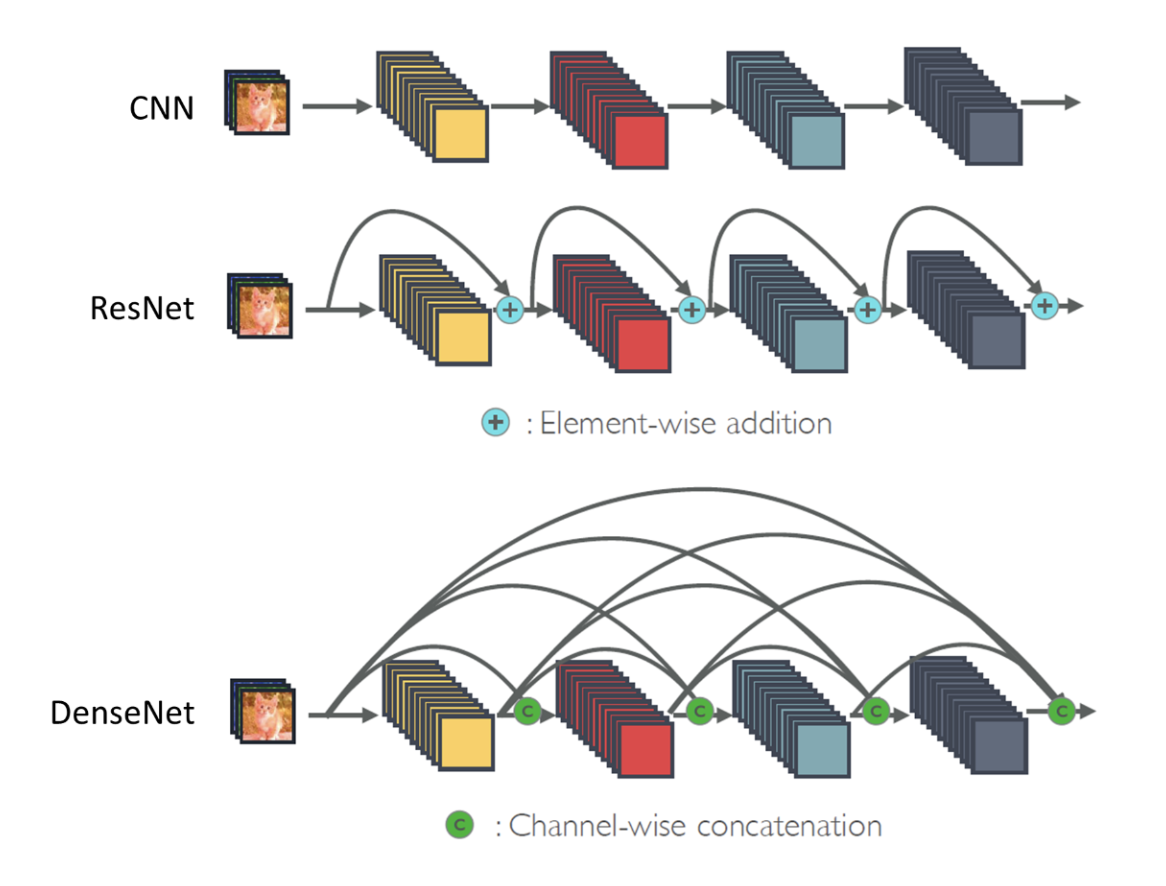



ResNet은 최종적으로 마지막 Layer 의 결과로 classification을 하는데,DenseNet은 전체 Layer 결과를 모두 반영하여 Classification을 할 수 있다. 그렇기 때문에 저자들은 DenseNet이 더 좋은 성능을 낸다고 주장한다.

하지만 모든 Layer을 다 연결하면 필연적으로 parameter 수가 급격하게 늘어난다.
때문에 DenseNet은 각 layer의 channerl 수 를 줄인다. channel 수를 많이 늘리지 않아도 모든 layer을 고려하기 때문에 성능에 문제가 없다는 것이다.

## 특징
* 모든 layer을 다 연결하기 때문에 gradient 전달이 잘 이루어짐
* parameter 수가 적음
* low한 feature도 반영이 가능하다.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

# DenseNet Block
def dense_block(x, num_layers, growth_rate):
    for _ in range(num_layers):
        bn = layers.BatchNormalization()(x)
        relu = layers.ReLU()(bn)
        conv = layers.Conv2D(growth_rate, kernel_size=3, padding='same')(relu)
        x = layers.Concatenate()([x, conv])
    return x

# Transition Block
def transition_block(x, compression_factor):
    num_channels = int(x.shape[-1])
    num_channels = int(num_channels * compression_factor)

    bn = layers.BatchNormalization()(x)
    relu = layers.ReLU()(bn)
    conv = layers.Conv2D(num_channels, kernel_size=1, padding='same')(relu)
    pool = layers.AveragePooling2D(pool_size=2, strides=2)(conv)
    return pool

# DenseNet Model
def create_densenet(input_shape, num_classes, num_blocks, num_layers_per_block, growth_rate, compression_factor):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(2 * growth_rate, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    for i in range(num_blocks - 1):
        x = dense_block(x, num_layers_per_block, growth_rate)
        x = transition_block(x, compression_factor)

    x = dense_block(x, num_layers_per_block, growth_rate)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.models.Model(inputs, outputs)
    return model


In [ ]:
input_shape = (32, 32, 3)  # Example input shape
num_classes = 10  # Example number of classes
num_blocks = 3  # Example number of blocks
num_layers_per_block = 4  # Example number of layers per block
growth_rate = 32  # Example growth rate
compression_factor = 0.5  # Example compression factor

model = create_densenet(input_shape, num_classes, num_blocks, num_layers_per_block, growth_rate, compression_factor)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]']

In [ ]:
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess)
ds_test = ds_test.map(preprocess)

batch_size = 64
ds_train = ds_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

input_shape = (32, 32, 3)
num_classes = 10
num_blocks = 3
num_layers_per_block = 4
growth_rate = 32
compression_factor = 0.5

model = create_densenet(input_shape, num_classes, num_blocks, num_layers_per_block, growth_rate, compression_factor)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 100
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')
model.fit(
    ds_train, epochs=epochs,
    validation_data=ds_test,
    callbacks=[es],
)

Epoch 1/100
782/782 [==============================] - 41s 25ms/step - loss: 1.3071 - accuracy: 0.5282 - val_loss: 2.1893 - val_accuracy: 0.3851
Epoch 2/100
782/782 [==============================] - 15s 19ms/step - loss: 0.9469 - accuracy: 0.6661 - val_loss: 1.4528 - val_accuracy: 0.5135
Epoch 3/100
782/782 [==============================] - 14s 18ms/step - loss: 0.7881 - accuracy: 0.7229 - val_loss: 2.0723 - val_accuracy: 0.4301
Epoch 4/100
782/782 [==============================] - 14s 18ms/step - loss: 0.6722 - accuracy: 0.7638 - val_loss: 1.6974 - val_accuracy: 0.5157
Epoch 5/100
782/782 [==============================] - 14s 17ms/step - loss: 0.5782 - accuracy: 0.7979 - val_loss: 1.1339 - val_accuracy: 0.6279
Epoch 6/100
782/782 [==============================] - 14s 18ms/step - loss: 0.4978 - accuracy: 0.8261 - val_loss: 1.0398 - val_accuracy: 0.6667
Epoch 7/100
782/782 [==============================] - 14s 18ms/step - loss: 0.4241 - accuracy: 0.8520 - val_loss: 1.1846 - val_ac

In [ ]:
loss, accuracy = model.evaluate(ds_test)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

157/157 [==============================] - 1s 6ms/step - loss: 1.5330 - accuracy: 0.7336
Test Loss: 1.533021330833435, Test Accuracy: 0.7336000204086304
